In [1]:
from typing import Callable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr

import network
from network import Weight
from preprocess_data import Game, PowerPlay, Situation, Venue, read_networks

In [2]:
def regular_networks():
    return read_networks(Situation.REGULAR)


def power_play_networks():
    return read_networks(Situation.POWER_PLAY)


def penalty_kill_networks():
    return read_networks(Situation.PENALTY_KILL)

In [3]:
def fit(df: pd.DataFrame, covariates: List[str], target: str, family: str = "binomial"):
    X = df[covariates]
    X = sm.add_constant(X)
    y = df[target]
    match family:
        case "binomial":
            model = sm.Logit(y, X)
        case "poisson":
            model = sm.GLM(y, X, family=sm.families.Poisson())
        case "gaussian":
            model = sm.OLS(y, X)
        case _:
            raise ValueError(f"{family} regression not implemented")
    res = model.fit()
    print(res.summary())

# Match Outcome Prediction

In [4]:
def get_win_df(features: List[Callable] | Callable) -> pd.DataFrame:
    """
    Builds a dataframe of features for each game using the regular situations (no Power Play and Penalty Kill).

    Args:
        features (List[Callable] | Callable): features to be computed for each game

    Returns:
        pd.DataFrame: Dataframe with columns game_str, log_n_passes, win, and features
    """
    if callable(features):
        features = [features]
    df = pd.DataFrame(
        [
            {"game_str": G.name, "n_passes": G.n_passes, "log_n_passes": np.log(G.n_passes), "win": G.win}
            | {feature.__name__: feature(G) for feature in features}
            for G in regular_networks()
        ]
    )
    return df

In [5]:
features = [
    network.assortativity,
    network.clustering,
    network.degree_mean,
    network.degree_std,
]
df = get_win_df(features)
df

,game_str,n_passes,log_n_passes,win,assortativity,clustering,degree_mean,degree_std
0,2022-02-08 Canada at USA_reg_home,216.0,5.375278,0,0.120174,0.461392,82.8,11.052602
1,2022-02-08 Canada at USA_reg_away,185.0,5.220356,1,-0.102773,0.474962,69.6,14.595890
2,2022-02-08 ROC at Finland_reg_home,265.0,5.579730,1,0.041894,0.493256,98.8,13.658697
3,2022-02-08 ROC at Finland_reg_away,200.0,5.298317,0,-0.120709,0.389216,74.4,20.867199
4,2022-02-12 Switzerland at ROC_reg_home,266.0,5.583496,0,-0.026035,0.497432,102.0,14.532722
5,2022-02-12 Switzerland at ROC_reg_away,212.0,5.356586,1,0.211820,0.476648,78.0,6.033241
6,2022-02-14 Switzerland at Canada_reg_home,331.0,5.802118,1,0.028629,0.674079,127.2,11.754148
7,2022-02-14 Switzerland at Canada_reg_away,147.0,4.990433,0,0.030374,0.296738,55.2,14.824304
8,2022-02-14 USA at Finland_reg_home,239.0,5.476464,0,0.077702,0.432872,89.2,16.375592
9,2022-02-14 USA at Finland_reg_away,220.0,5.393628,1,0.184663,0.563418,85.2,6.144917


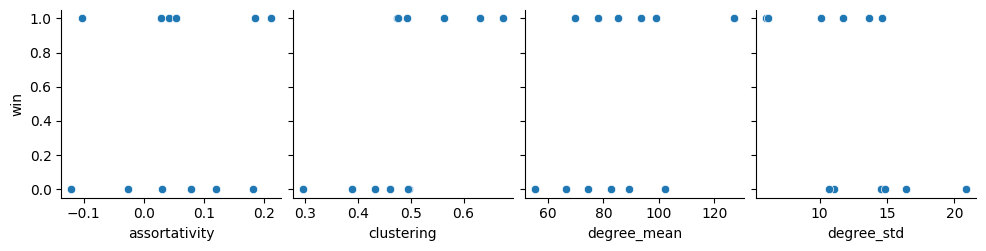

In [6]:
df = get_win_df(features)
sns.pairplot(df, x_vars=[feature.__name__ for feature in features], y_vars=["win"])

We control for number of total passes as in the paper. For degree_mean however, it doesn't make sense to control for number of passes. Indeed, `degree_mean` $=2n^{-1}$ `n_passes` and they are thus highly correlated.

In [7]:
pearsonr(df["n_passes"], df["degree_mean"]).statistic

0.9974096426196961

It would not be surprising if `degree_std` also was highly correlated with `n_passes` as we are dealing with non-negative count data (number of passes). However:

In [8]:
pearsonr(df["n_passes"], df["degree_std"]).statistic

-0.09744830556652813

In [9]:
controls = {
    network.assortativity: ["log_n_passes"],
    network.clustering: ["log_n_passes"],
    network.degree_mean: [],
    network.degree_std: ["log_n_passes"],
}

We don't look at connectivity ($\gamma$) and number of strongly connected components ($\sigma$) because our networks are all regular. 

In [10]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_win_df(feature)
    df.dropna(inplace=True)
    fit(df, covariates=[feature_name] + controls[feature], target="win", family="binomial")
    print("\n\n")

Feature: assortativity
Optimization terminated successfully.
         Current function value: 0.604426
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                   12
Model:                          Logit   Df Residuals:                        9
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.1280
Time:                        00:46:18   Log-Likelihood:                -7.2531
converged:                       True   LL-Null:                       -8.3178
Covariance Type:            nonrobust   LLR p-value:                    0.3448
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -24.5086     19.818     -1.237      0.216     -63.351      14.3

Conclusion: doesn't work. There are two possible explanations:
- We are using too little data
- The investigated features are not predictive

We have data from six games, giving twelve data points. Hence, it would not be surprising if that is not enough data.

# Power Play Success Prediction (Goal or nah)

In [11]:
def game_and_venue(G) -> Tuple[Game, Venue]:
    return (G.game.game, G.venue)


def get_pp_df(features: List[Callable] | Callable) -> pd.DataFrame:
    """
    Builds a dataframe of features for each Power Play for regressing on the success of the Power Play (goal or not) or
    the number of shots.

    Args:
        features (List[Callable] | Callable): features to be computed for each PP

    Returns:
        pd.DataFrame: Dataframe with columns game_str, log_n_passes, target, normal_feature_1, ..., normal_feature_n, pp_feature_1, ..., pp_feature_n
    """
    if callable(features):
        features = [features]
    regular_feature_map = {game_and_venue(G): {feature: feature(G) for feature in features} for G in regular_networks()}
    df = pd.DataFrame(
        [
            {
                "game_str": G.name,
                "n_passes": G.n_passes,
                "log_n_passes": np.log(G.n_passes),
                "goal": G.goal,
                "n_shots": G.n_shots,
            }
            | {f"normal_{feature.__name__}": regular_feature_map[game_and_venue(G)][feature] for feature in features}
            | {f"pp_{feature.__name__}": feature(G) for feature in features}
            for G in power_play_networks()
        ]
    )
    return df

In [12]:
get_pp_df(features).head(7)

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


,game_str,n_passes,log_n_passes,goal,n_shots,normal_assortativity,normal_clustering,normal_degree_mean,normal_degree_std,pp_assortativity,pp_clustering,pp_degree_mean,pp_degree_std
0,2022-02-08 Canada at USA_2_pp_home,27.0,3.295837,0,4,0.120174,0.461392,82.8,11.052602,-0.441123,0.221375,9.200000,4.955805
1,2022-02-08 Canada at USA_3_pp_home,21.0,3.044522,0,4,0.120174,0.461392,82.8,11.052602,-0.098857,0.291941,8.400000,2.727636
2,2022-02-08 Canada at USA_4_pp_home,15.0,2.708050,1,3,0.120174,0.461392,82.8,11.052602,-0.828079,0.220036,4.800000,1.469694
3,2022-02-08 Canada at USA_5_pp_home,11.0,2.397895,0,2,0.120174,0.461392,82.8,11.052602,0.683130,0.111614,4.400000,1.854724
4,2022-02-08 Canada at USA_6_pp_home,34.0,3.526361,0,6,0.120174,0.461392,82.8,11.052602,-0.282587,0.349990,11.600000,2.653300
5,2022-02-08 Canada at USA_1_pp_away,12.0,2.484907,1,1,-0.102773,0.474962,69.6,14.595890,-0.250000,0.567420,7.333333,1.247219
6,2022-02-08 ROC at Finland_4_pp_home,10.0,2.302585,1,2,0.041894,0.493256,98.8,13.658697,0.213201,0.000000,5.000000,2.549510


/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


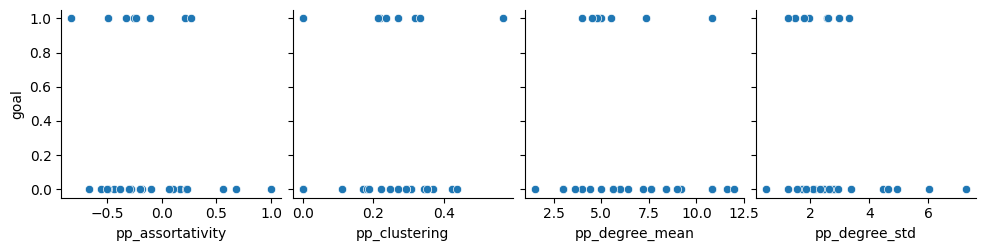

In [13]:
df = get_pp_df(features)
sns.pairplot(df, x_vars=[f"pp_{feature.__name__}" for feature in features], y_vars=["goal"])

In [14]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"normal_{feature_name}", f"pp_{feature_name}"] + controls[feature]
    fit(df, covariates=covariates, target="goal", family="binomial")
    print("\n\n")

Feature: assortativity
Optimization terminated successfully.
         Current function value: 0.467419
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                   30
Model:                          Logit   Df Residuals:                       26
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.1940
Time:                        00:46:21   Log-Likelihood:                -14.023
converged:                       True   LL-Null:                       -17.397
Covariance Type:            nonrobust   LLR p-value:                   0.08032
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.7448      3.804      1.773      0.076 

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


Optimization terminated successfully.
         Current function value: 0.525894
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                   31
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.07903
Time:                        00:46:21   Log-Likelihood:                -16.303
converged:                       True   LL-Null:                       -17.702
Covariance Type:            nonrobust   LLR p-value:                    0.4238
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7744      2.833      0.626      0.531      -3.778       7.327
normal_c

Also doesn't work.

# Predicting Number of Shots

Let's first see if `n_passes` predicts `n_shots`.

In [15]:
df = get_pp_df(features)
fit(df, covariates=["n_passes"], target="n_shots", family="poisson")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   31
Model:                            GLM   Df Residuals:                       29
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.081
Date:                Mon, 11 Dec 2023   Deviance:                       35.234
Time:                        00:46:21   Pearson chi2:                     36.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4820
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.283      0.035      0.9

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


It does. The number of passes is a significant predictor of the number of shots (p<0.0005). The coefficient is 0.0563, which means that all else equal, for every additional pass, we expect an increase in the number of shots by a factor of $e^{0.0563}\approx 0.057$ (remember that we use Poisson regression). This means for every ~18 passes a team will have an extra shot.

Let's see if the other network features are also predictive of the number of shots.

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


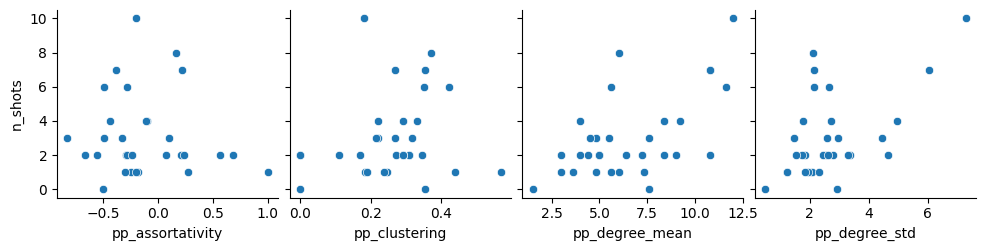

In [16]:
df = get_pp_df(features)
sns.pairplot(df, x_vars=[f"pp_{feature.__name__}" for feature in features], y_vars=["n_shots"])

In [17]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"pp_{feature_name}"] + controls[feature]
    fit(df, covariates=covariates, target="n_shots", family="poisson")
    print("\n\n")

Feature: assortativity
                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   30
Model:                            GLM   Df Residuals:                       27
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58.978
Date:                Mon, 11 Dec 2023   Deviance:                       35.029
Time:                        00:46:23   Pearson chi2:                     35.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3819
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   31
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.472
Date:                Mon, 11 Dec 2023   Deviance:                       36.017
Time:                        00:46:23   Pearson chi2:                     36.7
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4687
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.8479      0.746     -2.476

`degree_mean` is a significant predictor of `n_shots`. This is not surprising given the above as `degree_mean` is highly correlated with `n_passes`.

On the other hand, `assortativity` and `clustering` are also not predictive in this task.

We can also include the features from regular play (not power play) and see if the features become more predictive by being able to look at the contrast between normal play and power play.

In [18]:
for feature in features:
    feature_name = feature.__name__
    print(f"Feature: {feature_name}")
    df = get_pp_df(feature)
    df.dropna(inplace=True)
    covariates = [f"normal_{feature_name}", f"pp_{feature_name}"] + controls[feature]
    fit(df, covariates=covariates, target="n_shots", family="poisson")
    print("\n\n")

Feature: assortativity


                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   30
Model:                            GLM   Df Residuals:                       26
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.999
Date:                Mon, 11 Dec 2023   Deviance:                       33.072
Time:                        00:46:24   Pearson chi2:                     31.6
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4209
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.6913 

/home/fabio/miniconda3/envs/sn/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                n_shots   No. Observations:                   31
Model:                            GLM   Df Residuals:                       27
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.195
Date:                Mon, 11 Dec 2023   Deviance:                       35.463
Time:                        00:46:24   Pearson chi2:                     36.4
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4781
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.1096      0.82